In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15791153603142989769, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1278738744114583527
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16969647342131062428
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11276946637
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15511749360206926227
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 4.2 CNNによる画像分類

画像データは （C, H, W) の形で保持され、H, W は画像の縦と横のサイズ、C は色数あるいはチャンネルとも呼ばれる。  
もともとC=1, C=3だが、最終的には C は最後の畳み込み層のカーネル（フィルター）数になる。  
この処理によって得られた特徴量を MLP に入れて最終的なクラスの判別を行うという流れになる。  
畳み込みの後に位置の感度を鈍くするプーリングを挟むことや、Dropout や Batch Normalization とともに使用することも多々ある。

### 4.2.1 Fashion-MNIST

Fashion-MNIST は10カテゴリの洋服の画像データセットであり、28 × 28 のモノクロ画像である。  
PyTorch の拡張である torchvision というライブラリを使用することで簡単に Fashion-MNIST のデータをダウンロードし、 PyTorch の Dataset に変換し、 DataLoader を作成することが出来る。  

- https://github.com/zalandoresearch/fashion-mnist

In [3]:
## Fashion-MNIST のデータから DataLoader を作成
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 訓練用データを取得
# そのままだと PIL (Python Imaging Library) の画像形式で Dataset を作ってしまうので、transforms.ToTensor で Tensor に変換する
fashion_mnist_train = FashionMNIST("dataset/FashionMNIST", 
                                   train=True, download=True, transform=transforms.ToTensor())

# 検証用データの取得
fashion_mnist_test = FashionMNIST("dataset/FashionMNIST", 
                                  train=False, download=True, transform=transforms.ToTensor())

# バッチサイズが128の DataLoader をそれぞれ作成
batch_size = 128
train_loader = DataLoader(fashion_mnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test, batch_size=batch_size, shuffle=True)

Processing...
Done!


### 4.2.2 CNN の構築と学習

PyTorch には画像の畳込みを行う nn.Conv2d やプーリングを行う nn.MaxPool2d などが用意されており、すぐに CNN を構築できる。以下では、シンプルな2層の畳込み層と2層の MLP をつなげた CNN を作成している。  
PyTorch では nn.Linear は入力の次元を必ず指定しないといけないが、nn.Conv2d や nn.MaxPool2d でどのように画像のサイズが変わるのか、慣れないうちは計算するのが大変なので torch.ones 関数で作成したダミーでたーを入れて実際に計算する。

In [0]:
## 2層の畳み込み層と2層の MLP をつなげた CNN を作成

"""
(N, C, H, W) 形式を Tensor を (N, C*H*W) に引き伸ばす層
畳み込み層の出力を MLP にわたす際に必要
"""
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)
    
"""
5×5のカーネルを使用し最初に32個、次に64個のチャンネルを作成する
BatchNorm2d は画像形式用の Batch Normalization
Dropout2d は画像形式用の Dropout
最後に FlattenLayer を挟む
"""
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

"""
畳み込みによって最終的にどのようなサイズになっているかを、実際にダミーデータを入れてみて確認する
"""
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2層の NLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

# 最終的な CNN
net = nn.Sequential(
    conv_net,
    mlp
)

次に評価と訓練のヘルパー関数を作成する

In [0]:
# 評価のヘルパー関数
def eval_net(net, data_loader, device='cpu'):
    # Dropout や BatchNorm を無効化
    net.eval()  # ネットワークを評価モードにする
    ys = []
    ypreds = []
    for x, y in data_loader:
        # toメソッドで計算を実行するデバイスに転送する
        x = x.to(device)
        y = y.to(device)
        """確率が最大のクラスを予測（リスト2.14参照）
        ここでは forward(推論)の計算だけなので自動微分に
        必要な処理は off にして余計な計算を省く
        """
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 予測精度を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

In [0]:
# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader, 
              optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(), n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        net.train()  # ネットワークを訓練モードにする
        n = 0
        n_acc = 0
        # 非常に時間がかかるので tqdm を使用してプログレスモードを出す
        for i, (xx, yy) in tqdm(enumerate(train_loader), total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 訓練データの予測精度
        train_acc.append(n_acc / n)
        # 検証データの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        # この epoch での結果を表示: リストに追加された最新の値を取り出す
        print(epoch, train_losses[-1], train_acc[-1], val_acc[-1], flush=True)  # pythonで print の出力結果を即時・強制表示させる（主にjupyter）

In [14]:
# ネットワークの全パラメータを GPU に転送
net.to("cuda:0")

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")  # if GPU, add device="cuda:0" to argument

100%|██████████| 469/469 [00:10<00:00, 43.57it/s]


0 0.4557824441128307 0.8418833333333333 0.8757999539375305


100%|██████████| 469/469 [00:10<00:00, 43.43it/s]


1 0.31726221319956655 0.8840166666666667 0.8922999501228333


100%|██████████| 469/469 [00:10<00:00, 43.37it/s]


2 0.2832367192221503 0.8972166666666667 0.898099958896637


100%|██████████| 469/469 [00:10<00:00, 44.34it/s]


3 0.2621288763948231 0.90405 0.902899980545044


100%|██████████| 469/469 [00:10<00:00, 43.46it/s]


4 0.24436964245879242 0.9092333333333333 0.9068999886512756


100%|██████████| 469/469 [00:10<00:00, 44.06it/s]


5 0.22965878050806177 0.9147666666666666 0.9107999801635742


100%|██████████| 469/469 [00:10<00:00, 43.49it/s]


6 0.21860429464688158 0.9189166666666667 0.9104999899864197


100%|██████████| 469/469 [00:10<00:00, 43.61it/s]


7 0.2144771316844938 0.92085 0.9167999625205994


100%|██████████| 469/469 [00:10<00:00, 43.34it/s]


8 0.20420551608897683 0.9252833333333333 0.9164999723434448


100%|██████████| 469/469 [00:10<00:00, 43.46it/s]


9 0.19855982256241334 0.9248166666666666 0.91239994764328


100%|██████████| 469/469 [00:10<00:00, 42.74it/s]


10 0.19355238752805778 0.9280666666666667 0.9159999489784241


100%|██████████| 469/469 [00:11<00:00, 41.82it/s]


11 0.1852620575003899 0.931 0.920199990272522


100%|██████████| 469/469 [00:10<00:00, 43.17it/s]


12 0.1821073756003991 0.9324166666666667 0.9192999601364136


100%|██████████| 469/469 [00:11<00:00, 42.44it/s]


13 0.17633022733319265 0.9341 0.9080999493598938


100%|██████████| 469/469 [00:10<00:00, 43.73it/s]


14 0.1702161505818367 0.9365666666666667 0.9127999544143677


100%|██████████| 469/469 [00:10<00:00, 43.37it/s]


15 0.1680360142237101 0.9374166666666667 0.9213999509811401


100%|██████████| 469/469 [00:10<00:00, 43.68it/s]


16 0.1638129078424894 0.93865 0.92249995470047


100%|██████████| 469/469 [00:11<00:00, 41.39it/s]


17 0.15858463408887133 0.9395 0.9222999811172485


100%|██████████| 469/469 [00:11<00:00, 40.98it/s]


18 0.15470239636289257 0.9429333333333333 0.9192999601364136


100%|██████████| 469/469 [00:11<00:00, 40.97it/s]


19 0.15516457042824 0.9419666666666666 0.9199999570846558


## 4.3 転移学習

この節では**転移学習**という NN に見られる非常にユニークかつ有用な学習法について説明する。転移学習を用いるとあるタスクのために訓練済みのモデルを他のタスクにも流用でき、大量に学習データがなくても複雑なネットワークを訓練できるようになる。  

>- **VGG**: Oxford Univ. の VGG グループによって提案されたモデルで、3×3のように小さなカーネルを多数重ねることでモデルで表現呂姫雨を高めているという特徴を持つ。
- **Inception**: 別名 GoogleNet。Inception モジュールという疎な CNN を近似する構造を取り込み、総パラメータを減らしつつも深層化に成功したモデルである。  
- **ResNet**: Residual モジュールというショートカット構造を有し、前の層の入力もそのまま次の層に渡すことで勾配がより伝わりやすく、深いネットワークでも効率よく訓練できるように改良されたネットワーク構造のことである。

**転移学習（Transfer Learning）**とはあるタスク（ドメインとも）で得られたモデルをうまく他のタスクに転用する技術の総称である。こと画像認識の NN においては、事前に学習したネットワークの他の層のパラメータを全て固定し、最後の出力の線形層のみ自分のデータについて学習し直すとうまくいくことが経験的に知られている。特に ImageNet という大規模の画像認識データセットで事前に学習した ResNet などの様々なネットワークのパラメータが公開されており、転移学習に最適である。転移学習がうまくいく理由として、CNN の下位の層で画像を認識するのに必要となる一般的な特徴をうまく抽出できていると解釈されている。

### 4.3.1 データの準備

In [15]:
# ! wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
# ! tar -zxvf taco_and_burrito.tar.gz

--2019-02-11 11:44:40--  https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz [following]
--2019-02-11 11:44:40--  https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292798 (15M) [application/octet-stream]
Saving to: ‘taco_and_burrito.tar.gz’

taco_and_burrito.ta 100%[===================>]  14.58M  --.-KB/s    in 0.1s    

2019-02-11 11:44

In [21]:
! ls taco_and_burrito
! ls taco_and_burrito/train

test  train
burrito  taco


test にはそれぞれ30枚ずつ画像があり、train はそれ以外全部である。このディレクトリ構成にしておくと次のように torchvision の ImageFolder で読み込んで Dataset に用意に変換できる。  
PyTorch の ImageNet による学習済みモデルは 224×224 ピクセルの画像を入力として受け付けるのでこのサイズにクロップする。学習用データはより堅牢な学習結果にするためにランダムにクロップ（*RandomCrop*）し、検証用データは中心部をクロップ（*CenterCrop*）する。

In [0]:
## DataLoader を作成

from torchvision.datasets import ImageFolder
from torchvision import transforms

# ImageFolder 関数を使用して Dataset を作成する
train_imgs = ImageFolder("taco_and_burrito/train", 
                         transform = transforms.Compose([transforms.RandomCrop(224), transforms.ToTensor()])
                        )
test_imgs = ImageFolder("taco_and_burrito/test", 
                         transform = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])
                       )

# DataLoader を作成
train_loader = DataLoader(train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_imgs, batch_size=32, shuffle=True)

*ImageFolder* を使用すると指定したディレクトリのサブディレクトリ名をクラス名とし、そのディレクトリ以下の画像とクラスのインデックスの tuple を返す *Dataset* を作成できる。クラス名とクラスインデックスの対応は以下のように確認できる。

In [23]:
# クラス名とクラスインデックスの対応の確認

print( train_imgs.classes)
print( train_imgs.class_to_idx)

['burrito', 'taco']
{'burrito': 0, 'taco': 1}


### 4.3.2 PyTorch で転移学習

まずは事前学習済み（Pre-trained）のモデルをロードする。ここでは ResNet18 というモデルを使用する。  
**このモデルは出力の線形層が fc という名前で取得できる**ので、まずは全てのパラメータを微分対象から外し、その後 *fc* に新しい線形層をセットする。  
ここでは2クラスの分類なので線形層の出力の次元は2にする。新しくセットした層のパラメータはデフォルトで微分対象なので、これで最後の線形層のみの対象となる。

In [0]:
## 事前学習済み（Pre-trained）モデルのロードと定義
# （※ Ubuntu の環境で、2回目以降に実行する場合は、 .torch/models/resnet18-5c106cde.pth を削除して実行する）

from torchvision import models

# 事前学習済みの resnet18 のロード
net = models.resnet18(pretrained = True)

# 全てのパラメータを微分対象外にする
for p in net.parameters():
  p.requires_grad = False
  
# 最後の線形層を付け替える
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

モデルの定義は以上。後はこれまでと同様にモデルの訓練関数を書いていく。唯一の違いは fc のパラメータのみをオプティマイザーに渡す点である。（GPUで実行する）

In [0]:
## モデルの訓練関数の記述

def eval_net(net, data_loader, device='cpu'):
  # Dropout や BatchNorm を無効化
  net.eval()
  ys = []
  ypreds = []
  for x, y in data_loader:
    # to メソッドで計算を実行するデバイスに転送する
    x = x.to(device)
    y = y.to(device)
    """
    確率が最大のクラスを予測（リスト2.14）
    ここでは forward（推論）の計算だけなので自動微分に、必要な処理は off にして余計な計算を省く
    """
    with torch.no_grad():
      _, y_pred = net(x).max(1)
    ys.append(y)
    ypreds.append(y_pred)
  # ミニバッチごとの予測結果などを1つにまとめる
  ys = torch.cat(ys)
  ypreds = torch.cat(ypreds)
  # 予測精度を計算
  acc = (ys == ypreds).float().sum() / len(ys)
  return acc.item()

In [0]:
def train_net(net, train_loader, test_loader, 
              only_fc=True, optimizer_cls=optim.Adam, loss_fn=nn.CrossEntropyLoss(), n_iter=10, device='cpu'):
  train_losses = []
  train_acc = []
  val_acc = []
  if only_fc:
    # 最後の線形層のパラメータのみを optimizer に渡す
    optimizer = optimizer_cls(net.fc.parameters())
  else:
    optimizer = optimizer_cls(net.parameters())
  for epoch in range(n_iter):
    running_loss = 0.0
    # ネットワークを訓練モードにする
    net.train()
    n = 0
    n_acc = 0
    # 非常に時間がかかるので tqdm を使用してプログレスバーを出す
    for i, (xx, yy) in tqdm(enumerate(train_loader), total=len(train_loader)):
      xx = xx.to(device)
      yy = yy.to(device)
      h = net(xx)
      loss = loss_fn(h, yy)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      n += len(xx)
      _, y_pred = h.max(1)
      n_acc += (yy == y_pred).float().sum().item()
    train_losses.append(running_loss / i)
    # 訓練データの予測精度
    train_acc.append(n_acc / n)
    # 検証データの予測精度
    val_acc.append(eval_net(net, test_loader, device))
    # この epoch での結果を表示: リストに追加された最新の値を取り出す
    print("epoch: {} train_loss: {} train_acc: {} val_acc: {}".format(epoch, round(train_losses[-1],5), round(train_acc[-1],5), round(val_acc[-1],5), flush=True))  # pythonで print の出力結果を即時・強制表示させる（主にjupyter）
  return train_losses, train_acc, val_acc

In [55]:
## ネットワークの全パラメータを GPU に転送
net.to("cuda:0")

# 訓練を実行
train_losses, train_acc, val_acc = train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

  4%|▍         | 1/23 [00:00<00:04,  5.16it/s]

epoch: 0 train_loss: 0.48652 train_acc: 0.80618 val_acc: 0.75


  4%|▍         | 1/23 [00:00<00:04,  5.39it/s]

epoch: 1 train_loss: 0.43529 train_acc: 0.82163 val_acc: 0.83333


  4%|▍         | 1/23 [00:00<00:04,  5.46it/s]

epoch: 2 train_loss: 0.38071 train_acc: 0.86096 val_acc: 0.83333


  4%|▍         | 1/23 [00:00<00:03,  5.53it/s]

epoch: 3 train_loss: 0.38058 train_acc: 0.85674 val_acc: 0.75


  4%|▍         | 1/23 [00:00<00:04,  5.49it/s]

epoch: 4 train_loss: 0.36856 train_acc: 0.85112 val_acc: 0.81667


  4%|▍         | 1/23 [00:00<00:04,  5.42it/s]

epoch: 5 train_loss: 0.36953 train_acc: 0.84831 val_acc: 0.85


  4%|▍         | 1/23 [00:00<00:04,  5.24it/s]

epoch: 6 train_loss: 0.34435 train_acc: 0.85955 val_acc: 0.83333


  4%|▍         | 1/23 [00:00<00:04,  5.37it/s]

epoch: 7 train_loss: 0.35972 train_acc: 0.85253 val_acc: 0.86667


  4%|▍         | 1/23 [00:00<00:04,  5.42it/s]

epoch: 8 train_loss: 0.30943 train_acc: 0.87219 val_acc: 0.83333


  4%|▍         | 1/23 [00:00<00:04,  5.46it/s]

epoch: 9 train_loss: 0.31084 train_acc: 0.8764 val_acc: 0.88333


  4%|▍         | 1/23 [00:00<00:04,  5.29it/s]

epoch: 10 train_loss: 0.34275 train_acc: 0.87079 val_acc: 0.9


  4%|▍         | 1/23 [00:00<00:04,  5.37it/s]

epoch: 11 train_loss: 0.34603 train_acc: 0.84831 val_acc: 0.81667


  4%|▍         | 1/23 [00:00<00:04,  5.50it/s]

epoch: 12 train_loss: 0.32774 train_acc: 0.87219 val_acc: 0.86667


  4%|▍         | 1/23 [00:00<00:04,  5.50it/s]

epoch: 13 train_loss: 0.34226 train_acc: 0.87079 val_acc: 0.9


  4%|▍         | 1/23 [00:00<00:04,  5.45it/s]

epoch: 14 train_loss: 0.32624 train_acc: 0.86096 val_acc: 0.88333


  4%|▍         | 1/23 [00:00<00:03,  5.54it/s]

epoch: 15 train_loss: 0.29716 train_acc: 0.88062 val_acc: 0.81667


  4%|▍         | 1/23 [00:00<00:04,  5.35it/s]

epoch: 16 train_loss: 0.30108 train_acc: 0.86096 val_acc: 0.86667


  4%|▍         | 1/23 [00:00<00:04,  5.29it/s]

epoch: 17 train_loss: 0.309 train_acc: 0.8736 val_acc: 0.85


  4%|▍         | 1/23 [00:00<00:04,  5.45it/s]

epoch: 18 train_loss: 0.3202 train_acc: 0.85955 val_acc: 0.86667


100%|██████████| 23/23 [00:04<00:00,  5.60it/s]


epoch: 19 train_loss: 0.28736 train_acc: 0.87921 val_acc: 0.88333


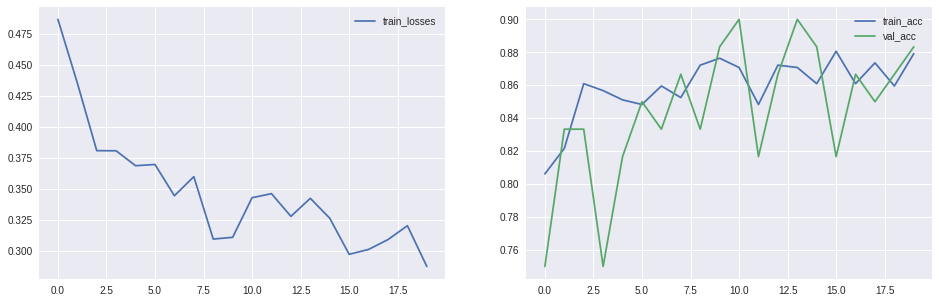

In [63]:
plt.figure(figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train_losses")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.show()

fc 層以外はパラメータが変化せず、毎回同じ計算を無駄に行っているとも言えるので事前に計算してそれを入力とするロジスティック回帰モデルを訓練するというのも良い。最後の fc 層を除去する方法は様々あるが、以下のように入力をそのまま出力するダミーの層を作り、fc を置き換えるというのが汎用性が高い。

In [0]:
## 入力をそのまま出力するダミーの層を作り、fc を置き換える

class IdentifyLayer(nn.Module):
    def forward(self, x):
         return x
  
net = models.resnet18(pretrained = True)
for p in net.parameters():
    p.requires_grad = False
net.fc = IdentifyLayer()

## 4.4 CNN 回帰モデルによる画像の高解像度化